Пусть $Y|\theta \sim \cal{N}(\theta, σ^2)$, где $σ^2$ известна, но $\theta$ неизвестно. Априорно $\theta \sim \cal{N}(μ,\tau^2)$ для некторых известных констант $μ$ и $\tau^2$.
Используя алгоритм Метрополиса — Гастингса найдем постериорные среднее и диспресию $\theta$ после наблюдения значения $Y$. А также, сравним три trace plots соответствующие трем различным значениям стандартного отклонения d для proposals (d = 100, d = 1, и d = 0.01).

$$f_{\theta|Y}(\theta|y) \propto f_{Y|\theta}(y|\theta)f_{\theta}(\theta) \propto e^{−\frac{1}{2\sigma^2}(y-\theta)^2} e^{−\frac{1}{2\tau^2}(\theta-\mu)^2}$$.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.size'] = 14

tfont = {'family': 'monospace',
         'color':  'black',
         'weight': 'heavy',
         'size': 18}

lfont = {'family': 'monospace',
         'color':  'black',
         'weight': 'normal',
         'size': 16}

class MetropolisHasting:
    def __init__(self, mu, tau, sigma, d, y, n_iter=10_000):
        self.mu = mu
        self.tau = tau
        self.sigma = sigma
        self.d = d
        self.y = y

        self.theta = np.ones(shape=(1, n_iter))[0] * self.mu
        self.n_iter = n_iter

    def make_step(self, x_curr):

        # Make a propose
        epsilon = np.random.normal(loc=0, scale=self.d)
        x_prop = x_curr + epsilon

        # Acceptance probability for the propose
        f_prop = np.exp(-1 / (2 * self.sigma ** 2) * (self.y - x_prop) ** 2) * np.exp(
            -1 / (2 * self.tau ** 2) * (x_prop - self.mu) ** 2)
        f_curr = np.exp(-1 / (2 * self.sigma ** 2) * (self.y - x_curr) ** 2) * np.exp(
            -1 / (2 * self.tau ** 2) * (x_curr - self.mu) ** 2)

        alpha = min(f_prop / f_curr, 1)

        # Try to accept the propose
        if np.random.binomial(n=1, p=alpha, size=1)[0]:
            return x_prop
        else:
            return x_curr

    def simulate(self):
        for i in range(self.n_iter-1):
            self.theta[i+1] = self.make_step(self.theta[i])

    def sample_mean(self):
        return 1/self.n_iter * sum(self.theta)

    def sample_variance(self):
        return 1/(self.n_iter - 1) * sum(np.square(self.theta - self.sample_mean()))

    def theta_plot(self):
        fig, ax = plt.subplots()

        theta_prec, y_prec = 1/self.tau**2, 1/self.sigma**2
        loc = y_prec / (y_prec + theta_prec) * self.y + theta_prec / (y_prec + theta_prec) * self.mu
        scale = np.sqrt(1 / (y_prec + theta_prec))

        xs = np.linspace(norm.ppf(0.001, loc, scale), norm.ppf(0.999, loc, scale), 100)

        ax.hist(self.theta, density=True, bins='auto', color='grey', alpha=0.2, label='empirical pdf')
        ax.plot(xs, norm.pdf(xs, loc, scale), 'r-', lw=5, alpha=0.2, label='true pdf')   
        
        ax.set_xlabel('theta', fontdict=lfont)
        ax.set_ylabel('density', fontdict=lfont)
        
        ax.set_title(f'True and empirical PDFs', fontdict=tfont)
        ax.legend()

        plt.show()

    def trace_plot(self):
        fig, ax = plt.subplots()

        ax.plot(self.theta, color='grey', alpha=0.8)
        
        ax.set_xlabel('n', **lfont)
        ax.set_ylabel('theta', **lfont)
        
        ax.set_title(f'Trace plot for d = {self.d}', fontdict=tfont)
        
        plt.show()
    
    def sample_cdf(self):
        
        theta_prec, y_prec = 1/self.tau**2, 1/self.sigma**2
        loc = y_prec / (y_prec + theta_prec) * self.y + theta_prec / (y_prec + theta_prec) * self.mu
        scale = np.sqrt(1 / (y_prec + theta_prec))

        fig, ax = plt.subplots()

        # Построение выборочной функции распределения
        x, y = np.sort(self.theta), np.arange(1, self.n_iter+1) / self.n_iter
        ax.step(x, y, where='post', c='grey', lw=2, alpha=0.8, label='empirical cdf')

        # Построение истинной функции распределения
        xs = np.linspace(norm.ppf(0.001, loc, scale), norm.ppf(0.999, loc, scale), 100)
        ax.plot(xs, norm.cdf(xs, loc, scale), 'r-', lw=4, alpha=0.2, label='true cdf')
        
        ax.set_xlabel('theta', fontdict=lfont)
        ax.set_ylabel('probability', fontdict=lfont)

        ax.set_title(f'True and empirical CDFs', fontdict=tfont)
        ax.legend()
        
        plt.show()

    def conv_visual(self):
        
        bounds = [int(self.n_iter ** p) for p in np.arange(0.25, 1.25, 0.25)]
        
        cdfs = []
        for n in bounds:
            x, y = np.sort(self.theta[:n]), np.arange(1, n+1) / n
            cdfs.append((x, y))
        
        theta_prec, y_prec = 1/self.tau**2, 1/self.sigma**2
        loc = y_prec / (y_prec + theta_prec) * self.y + theta_prec / (y_prec + theta_prec) * self.mu
        scale = np.sqrt(1 / (y_prec + theta_prec))
        
        for x, y in cdfs:

            fig, ax = plt.subplots()

            # Построение выборочной функции распределения
            ax.step(x, y, where='post', c='grey', lw=2, alpha=0.8, label='empirical cdf')

            # Построение истинной функции распределения
            xs = np.linspace(norm.ppf(0.001, loc, scale), norm.ppf(0.999, loc, scale), 100)
            ax.plot(xs, norm.cdf(xs, loc, scale), 'r-', lw=4, alpha=0.2, label='true cdf')

            # Нанесение подвыборки на ось абсцисс 
            ax.scatter(x, np.zeros(len(x))-0.04, c='grey', alpha=0.2, label='theta_i')
            
            ax.set_xlabel('theta', fontdict=lfont)
            ax.set_ylabel('probability', fontdict=lfont)

            ax.set_title(f'CDFs for n = {len(x)}', fontdict=tfont)
            ax.legend()

            plt.show()
                   
    def all_in_one(self):
        
        fig, ax = plt.subplots(7, figsize=(24, 112))

        theta_prec, y_prec = 1/self.tau**2, 1/self.sigma**2
        loc = y_prec / (y_prec + theta_prec) * self.y + theta_prec / (y_prec + theta_prec) * self.mu
        scale = np.sqrt(1 / (y_prec + theta_prec))

        xs = np.linspace(norm.ppf(0.001, loc, scale), norm.ppf(0.999, loc, scale), 100)
        
        # PDFs
        ax[0].hist(self.theta, density=True, bins='auto', color='grey', alpha=0.2, label='empirical pdf')
        ax[0].plot(xs, norm.pdf(xs, loc, scale), 'r-', lw=5, alpha=0.2, label='true pdf')  
        
        ax[0].set_xlabel('theta', fontdict=lfont)
        ax[0].set_ylabel('density', fontdict=lfont)
        
        ax[0].set_title(f'True and empirical PDFs', fontdict=tfont)
        ax[0].legend()
        
        #CDFs
        x, y = np.sort(self.theta), np.arange(1, self.n_iter+1) / self.n_iter
        ax[1].step(x, y, where='post', c='grey', lw=2, alpha=0.8, label='empirical cdf')

        xs = np.linspace(norm.ppf(0.001, loc, scale), norm.ppf(0.999, loc, scale), 100)
        ax[1].plot(xs, norm.cdf(xs, loc, scale), 'r-', lw=4, alpha=0.2, label='true cdf')
        
        ax[1].set_xlabel('theta', fontdict=lfont)
        ax[1].set_ylabel('probability', fontdict=lfont)

        ax[1].set_title(f'True and empirical CDFs', fontdict=tfont)
        ax[1].legend()
        
        # Trace plot
        ax[2].plot(self.theta, color='grey', alpha=0.8)
        
        ax[2].set_xlabel('n', **lfont)
        ax[2].set_ylabel('theta', **lfont)
        
        ax[2].set_title(f'Trace plot for d = {self.d}', fontdict=tfont)
        
        # Evolution
        
        bounds = [int(self.n_iter ** p) for p in np.arange(0.25, 1.25, 0.25)]
        
        cdfs = []
        for n in bounds:
            x, y = np.sort(self.theta[:n]), np.arange(1, n+1) / n
            cdfs.append((x, y))
        
        theta_prec, y_prec = 1/self.tau**2, 1/self.sigma**2
        loc = y_prec / (y_prec + theta_prec) * self.y + theta_prec / (y_prec + theta_prec) * self.mu
        scale = np.sqrt(1 / (y_prec + theta_prec))
        
        i = 3
        for x, y in cdfs:

            # Построение выборочной функции распределения
            ax[i].step(x, y, where='post', c='grey', lw=2, alpha=0.8, label='empirical cdf')

            # Построение истинной функции распределения
            xs = np.linspace(norm.ppf(0.001, loc, scale), norm.ppf(0.999, loc, scale), 100)
            ax[i].plot(xs, norm.cdf(xs, loc, scale), 'r-', lw=4, alpha=0.2, label='true cdf')

            # Нанесение подвыборки на ось абсцисс 
            ax[i].scatter(x, np.zeros(len(x))-0.04, c='grey', alpha=0.2, label='theta_i')
            
            ax[i].set_xlabel('theta', fontdict=lfont)
            ax[i].set_ylabel('probability', fontdict=lfont)

            ax[i].set_title(f'CDFs for n = {len(x)}', fontdict=tfont)
            ax[i].legend()
            
            i += 1
        
        plt.show()

In [15]:
mh = MetropolisHasting(mu=0, tau=2, sigma=1, d=1, y=3, n_iter=10_000)
mh.simulate()

In [17]:
mh.sample_mean()

2.3550793698301122

In [19]:
mh.sample_variance()

0.9494692576209204

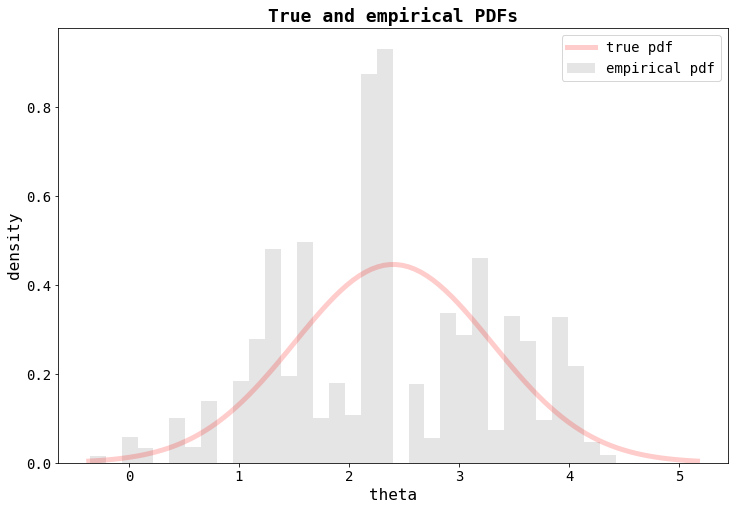

In [16]:
mh.theta_plot()

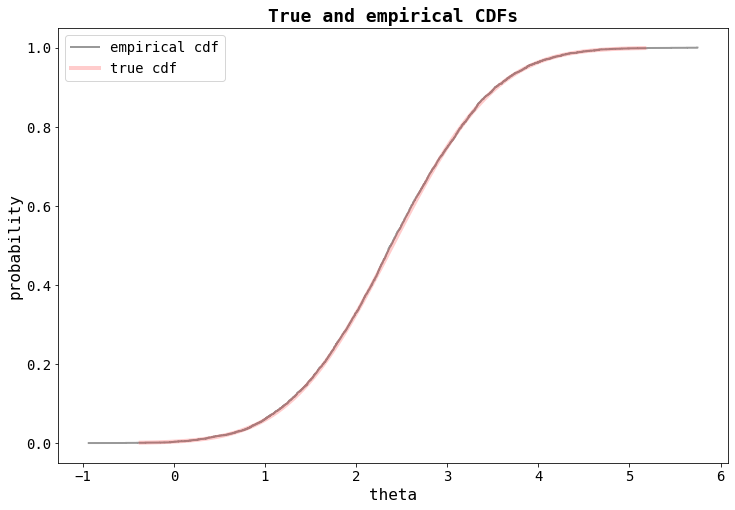

In [462]:
mh.sample_cdf()

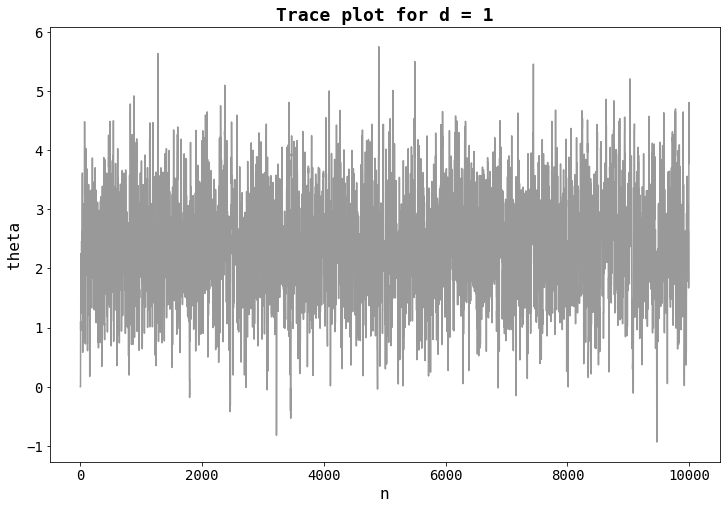

In [463]:
mh.trace_plot()

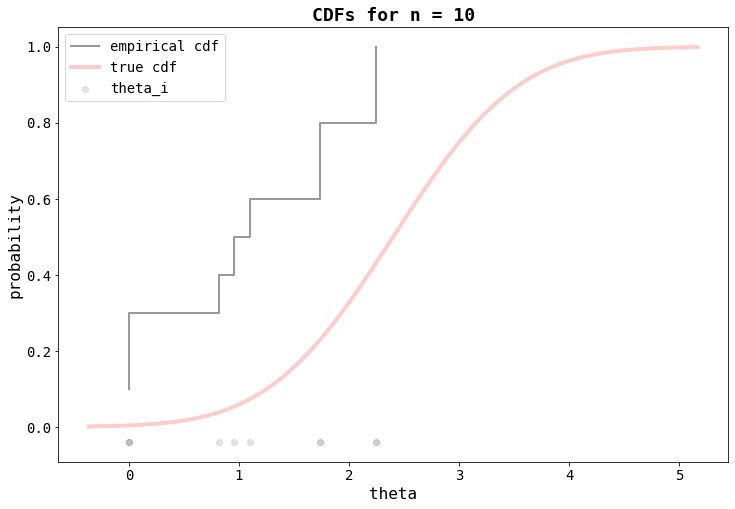

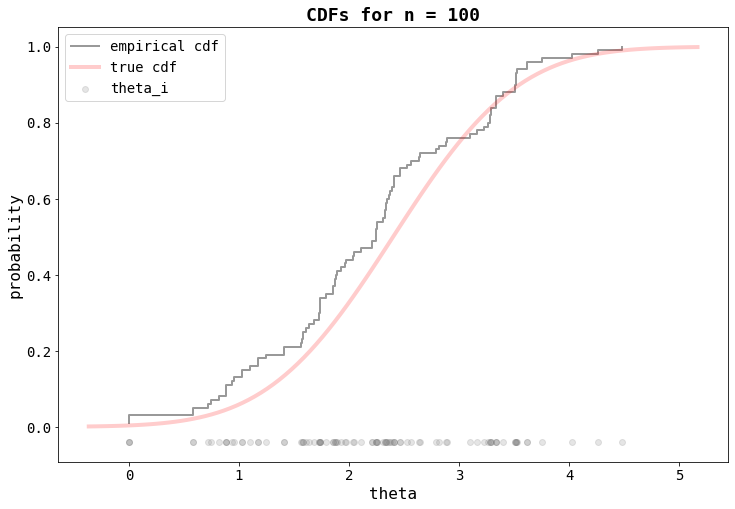

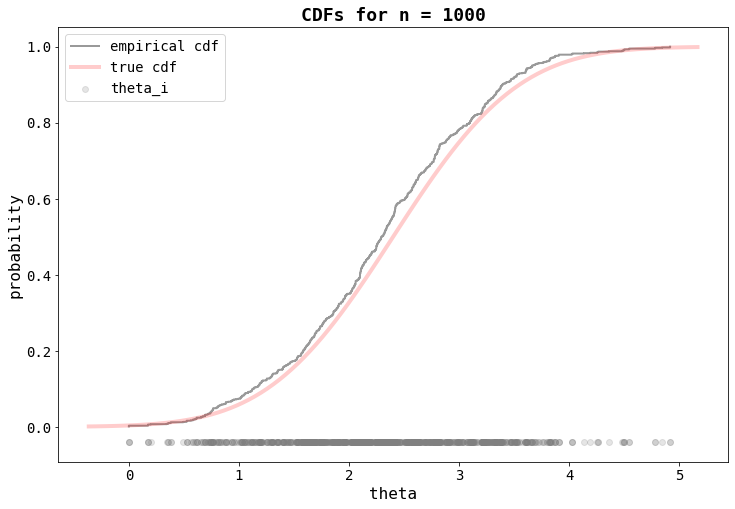

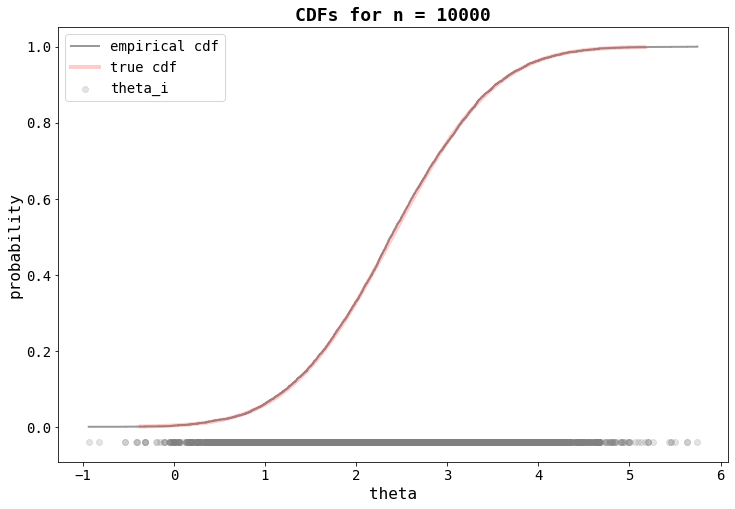

In [466]:
mh.conv_visual()

In [2]:
import os

os.getcwd()
os.chdir('/Users/pavelkiselev/Downloads')
os.getcwd()

'/Users/pavelkiselev/Downloads'

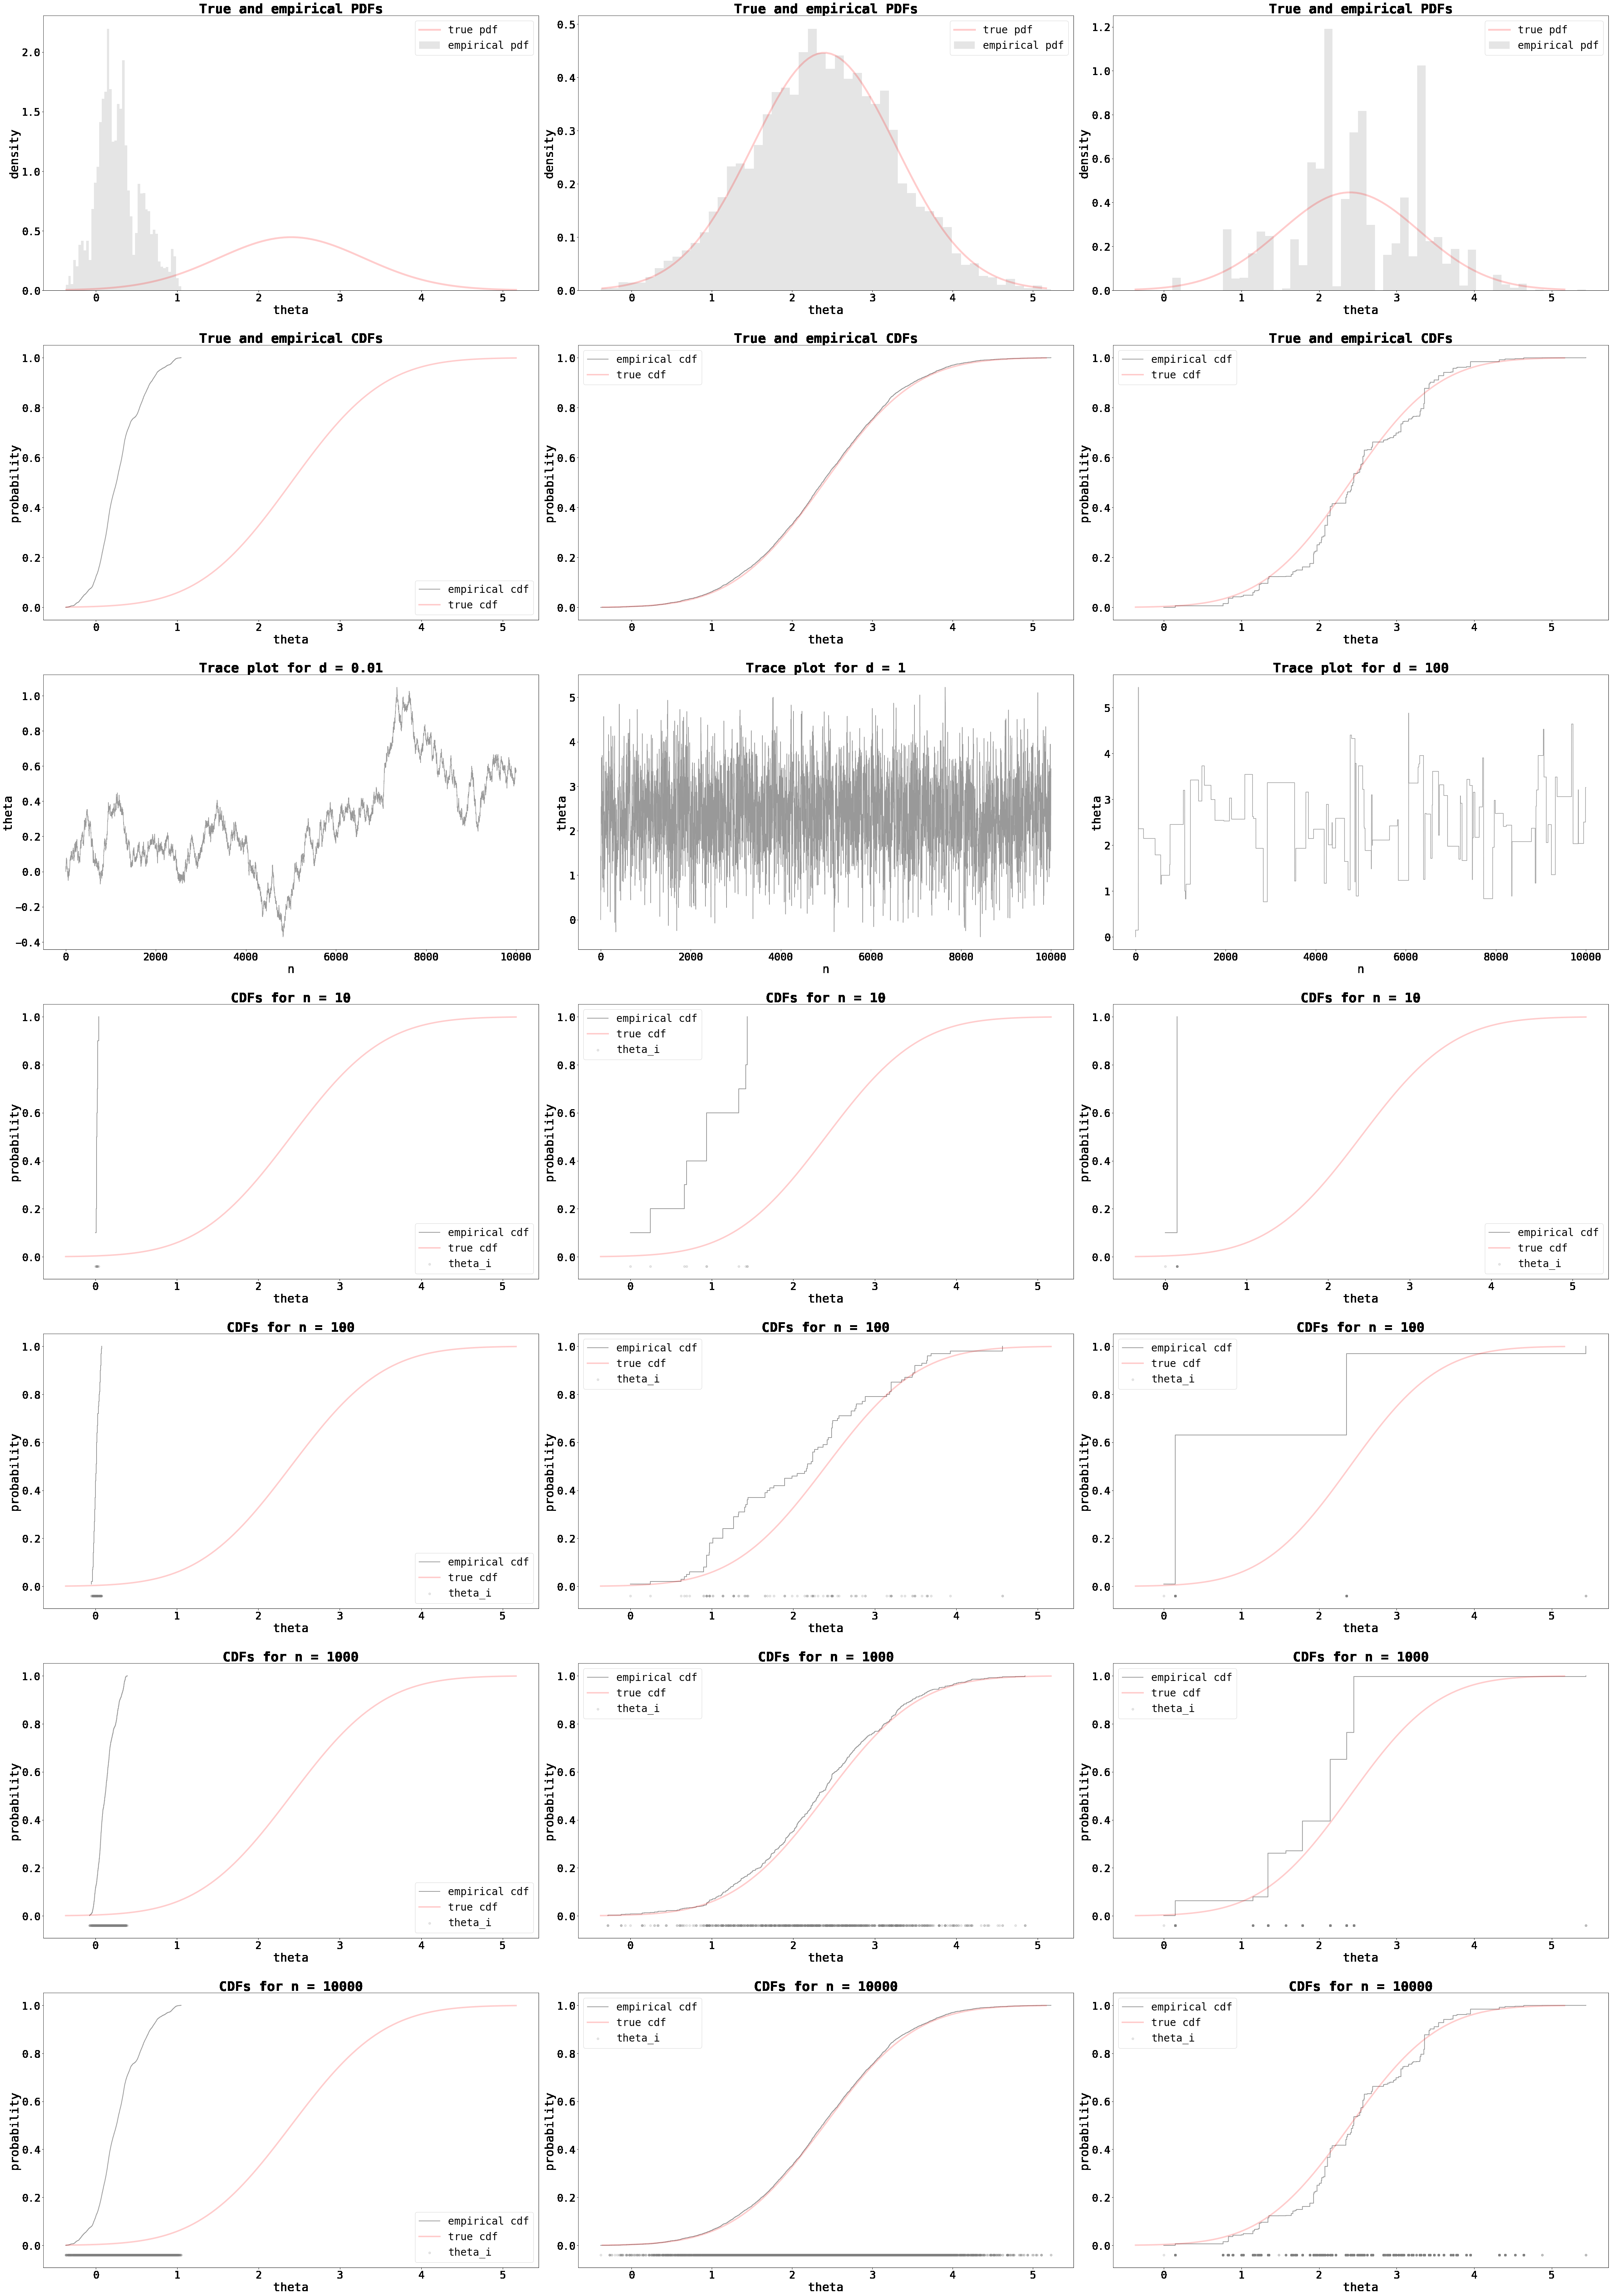

In [3]:
from IPython.display import Image
Image(filename='comparison_2.png')